In [1]:
import pandas as pd
import numpy as np
import h2o
from h2o.estimators import H2OGradientBoostingEstimator
from h2o.estimators import H2OXGBoostEstimator
from h2o.grid.grid_search import H2OGridSearch
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve, auc

In [2]:
h2o.init(port=12345)

Checking whether there is an H2O instance running at http://localhost:12345..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "21.0.5" 2024-10-15; OpenJDK Runtime Environment (build 21.0.5+11-Ubuntu-1ubuntu124.04); OpenJDK 64-Bit Server VM (build 21.0.5+11-Ubuntu-1ubuntu124.04, mixed mode, sharing)
  Starting server from /home/lucasmalheiros/Documents/Pesquisa Operacional/tcc-relax-and-fix/venv/lib/python3.12/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpqo4zcd69
  JVM stdout: /tmp/tmpqo4zcd69/h2o_lucasmalheiros_started_from_python.out
  JVM stderr: /tmp/tmpqo4zcd69/h2o_lucasmalheiros_started_from_python.err
  Server is running at http://127.0.0.1:12345
Connecting to H2O server at http://127.0.0.1:12345 ... successful.


H2O_cluster_uptime:,06 secs
H2O_cluster_timezone:,America/Sao_Paulo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,1 month and 4 days
H2O_cluster_name:,H2O_from_python_lucasmalheiros_230ljg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.868 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [3]:
def convert_to_h2o_frame(data: pd.DataFrame) -> h2o.H2OFrame:
    """Converte um pd.DataFrame em um h2o.H2OFrame"""
    print('Performing conversion from pd.DataFrame to h2o.H2OFrame...')
    # Colunas de datas
    cols_to_date = [col for col in data.dtypes[data.dtypes == 'datetime64[ns]'].index]
    # Colunas a converter para categórica
    cols_to_factor = [col for col in data.dtypes[(data.dtypes == 'object') | (data.dtypes == 'category')].index]
    # Colunas a converter a numeric
    cols_numerics = [col for col in data.dtypes[(data.dtypes != 'object') & (data.dtypes != 'category') & (data.dtypes != 'datetime64[ns]')].index]
    # Adicionar os tipos de colunas ao dicionário col_dtypes
    col_dtypes = {}
    for col in cols_to_date:
        col_dtypes[col] = 'time'
    for col in cols_to_factor:
        col_dtypes[col] = 'enum'
    for col in cols_numerics:
        col_dtypes[col] = 'numeric'
    # Converte a h2o
    data = h2o.H2OFrame(data, column_types=col_dtypes, na_strings=['NA', 'none', 'None', 'nan', 'NaN', '<NA>'])
    print('Successful conversion from pd.DataFrame to h2o.H2OFrame.')
    return data

# Data preparation

In [4]:
# Resultados
df_resultados = pd.read_csv('resultados_instancias_tcc.csv')
df_resultados = df_resultados[['Instancias'] + [col for col in df_resultados.columns if col.startswith('Obj_') or col.startswith('Time_')]]
df_resultados = df_resultados[df_resultados['Obj_RF_T_0'] != np.inf]  # Remove infactíveis

In [5]:
# Features criadas de create_features_dataset.py
df_features = pd.read_csv('multi_plant_instance_features.csv')

In [6]:
df = df_features.merge(df_resultados, left_on='instance', right_on='Instancias', how='inner').drop(columns=['Instancias', 'instance'])

In [7]:
df.head(3)

,num_products,num_plants,num_periods,binary_vars,total_demand,avg_demand_per_product,variance_demand_per_product,std_demand_per_product,mean_utilization,max_utilization,...,Obj_RF_4_2,Time_RF_4_2,Obj_RF_4_3,Time_RF_4_3,Obj_RF_6_0,Time_RF_6_0,Obj_RF_6_1,Time_RF_6_1,Obj_RF_T_0,Time_RF_T_0
0,120,2,12,2880,263136,91.366667,2807.950972,52.990103,1.000118,1.067356,...,NaN,NaN,NaN,NaN,829221.10,1800.13,811118.49,1200.63,809910.65,1800.1
1,60,20,12,14400,1305703,90.673819,2699.046453,51.952348,1.000154,1.143479,...,NaN,NaN,NaN,NaN,2404264.97,1069.06,2404219.27,1018.31,2404240.72,952.5
2,120,6,12,8640,788211,91.228125,2765.053630,52.583777,0.999516,1.092181,...,NaN,NaN,NaN,NaN,2000140.81,1800.32,1991086.02,1214.94,2106419.81,1800.2


# Construção de targets

In [8]:
obj_columns = [col for col in df.columns if col.startswith('Obj_')]
time_columns = [col for col in df.columns if col.startswith('Time_')]

## Target em função objetivo (BEST)

In [9]:
# Seleciona para cada instância o método com menor função objetivo para a coluna BEST
df['BEST'] = df[obj_columns].idxmin(axis=1)
df['BEST'] = df['BEST'].str.replace('Obj_', '')

In [10]:
df['BEST'].value_counts()

BEST
RF_T_0    221
RF_6_0     73
RF_3_1     60
RF_2_0     52
RF_1_0     48
RF_6_1     45
RF_2_1     36
RF_3_0     33
RF_4_0     30
Name: count, dtype: int64

## Target com compromisso de tempo (BEST_TIME)

In [11]:
for obj_col, time_col in zip(obj_columns, time_columns):
    df[f'Adjusted_{obj_col}'] = (
        df[obj_col] * np.maximum(np.log(df[time_col]) / np.log(1000), 1)
    )
adjusted_columns = [col for col in df.columns if col.startswith('Adjusted_')]

In [12]:
# Seleciona para cada instância o método com menor função objetivo para a coluna BEST
df['BEST_TIME'] = df[adjusted_columns].idxmin(axis=1)
df['BEST_TIME'] = df['BEST_TIME'].str.replace('Adjusted_Obj_', '')

In [13]:
df['BEST_TIME'].value_counts()

BEST_TIME
RF_T_0    119
RF_1_0    115
RF_3_1     72
RF_6_0     72
RF_6_1     69
RF_2_0     58
RF_2_1     35
RF_3_0     30
RF_4_0     28
Name: count, dtype: int64

# Preprocessamento de dados

## Drop Obj_ e Time_

In [14]:
df = df.drop(columns=obj_columns + time_columns + adjusted_columns)

In [15]:
# Embaralhar dataset
df = df.sample(frac=1)

## Convert para H2O frame

In [16]:
# Conversão para H2O frame
hf = convert_to_h2o_frame(df)

Performing conversion from pd.DataFrame to h2o.H2OFrame...
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Successful conversion from pd.DataFrame to h2o.H2OFrame.


In [17]:
# Train test split
hf_train, hf_test = hf.split_frame(ratios=[.8], seed=2112)

# Treino (GBM)

In [18]:
target = 'BEST_TIME'
predictors = [c for c in hf_train.columns if c not in ['BEST', 'BEST_TIME']]

In [19]:
gbm_model = H2OGradientBoostingEstimator(
    nfolds=10,
    keep_cross_validation_predictions=True,
    seed=2112,
    stopping_rounds=10,
    stopping_metric="AUTO",
    stopping_tolerance=0.001,
    balance_classes=False
)

In [20]:
xgboost_model = H2OXGBoostEstimator(booster='dart',
                                    normalize_type="tree",
                                    seed=2112,
                                    nfolds=10,
                                    keep_cross_validation_predictions=True)

In [21]:
# Hiper Parâmetros
hyper_params = {
    "learn_rate": list(
        np.round(np.arange(0.01, 0.1, 0.01), 3)
    ),  # Narrowed range for learning rate list(np.round(np.arange(0.05, 0.3, 0.05), 3)),
    "max_depth": list(
        np.arange(5, 10, 1)
    ),  # Reduced maximum depth list(np.arange(5, 15, 1)),
    "ntrees": list(
        np.arange(50, 150, 20)
    ),  # Increased number of trees list(np.arange(20, 70, 10)),
    "sample_rate": list(
        np.round(np.arange(0.5, 0.9, 0.1), 3)
    ),  # Adjusted sample rate range list(np.round(np.arange(0.5, 1.0, 0.1), 3)),
    "col_sample_rate": list(
        np.round(np.arange(0.5, 1.0, 0.1), 3)
    ),  # Slightly adjusted col sample rate range list(np.round(np.arange(0.3, 1.0, 0.1), 3)),
}
# Tipo de pesquisa da grid. Em caso de RandomDiscrete, corre até max_models(n modelos)
search_criteria = {
    "strategy": "RandomDiscrete",
    "max_models": 50,
    # "max_runtime_secs": 180,
    "seed": 1
}

In [22]:
# # Construir grid com parâmetros e critérios de procura de melhor modelo
# grid = H2OGridSearch(model=gbm_model, 
#                      search_criteria=search_criteria, 
#                      hyper_params=hyper_params)
# # Treinar grid
# grid.train(x=predictors, y=target, training_frame=hf_train);

In [23]:
# gbm_grid = grid.get_grid(sort_by="rmse", decreasing=False)
# model = gbm_grid.models[0]

In [24]:
model = gbm_model
model.train(x=predictors, y=target, training_frame=hf_train);

gbm Model Build progress: |

/home/lucasmalheiros/Documents/Pesquisa Operacional/tcc-relax-and-fix/venv/lib/python3.12/site-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [num_periods]
  warnings.warn(mesg["message"], RuntimeWarning)
/home/lucasmalheiros/Documents/Pesquisa Operacional/tcc-relax-and-fix/venv/lib/python3.12/site-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: early stopping is enabled but neither score_tree_interval or score_each_iteration are defined. Early stopping will not be reproducible!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%


# Avaliação das métricas de treino

In [25]:
# Variáveis mais importantes na escolha
importancia_var = model.varimp(use_pandas=True)
importancia_var

,variable,relative_importance,scaled_importance,percentage
0,max_setup_cost,163.674973,1.000000,0.125240
1,total_transportation_cost,158.564621,0.968777,0.121330
2,max_utilization,106.451439,0.650383,0.081454
3,min_utilization,96.961655,0.592404,0.074193
4,demand_to_capacity_ratio,84.933083,0.518913,0.064989
5,total_demand,72.963951,0.445786,0.055830
6,std_utilization,65.581200,0.400679,0.050181
7,setup_to_production_cost_ratio,58.457039,0.357153,0.044730
8,std_setup_cost,55.754055,0.340639,0.042662
9,avg_demand_to_setup_cost_ratio,51.582096,0.315150,0.039469


PartialDependencePlot progress: |

████████████████████████████████████████████████| (done) 100%


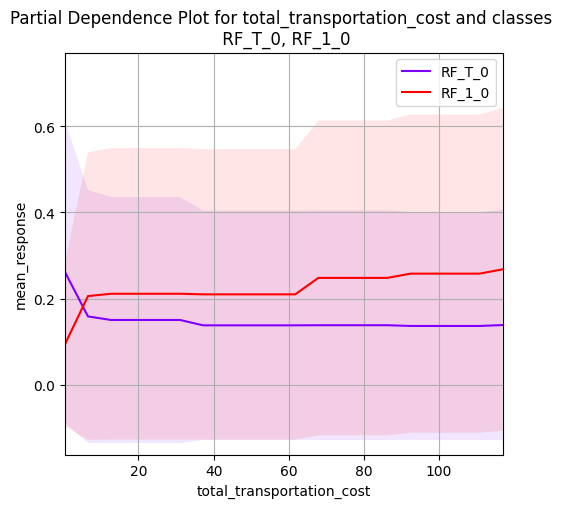

In [26]:
model.partial_plot(frame=hf_train, cols=['total_transportation_cost'], figsize=(5, 5), targets=['RF_T_0', 'RF_1_0']);

In [27]:
# Previsões
actual = hf_train[target].as_data_frame(use_multi_thread=True)[target]
predictions = model.cross_validation_holdout_predictions()
predict = predictions[0].as_data_frame(use_multi_thread=True)['predict']

/home/lucasmalheiros/Documents/Pesquisa Operacional/tcc-relax-and-fix/venv/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/lucasmalheiros/Documents/Pesquisa Operacional/tcc-relax-and-fix/venv/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [28]:
# Confusion matrix
cm = confusion_matrix(actual, predict)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[79  9  1  1  0  3  0  3  2]
 [14 16  6  5  1  2  4  1  0]
 [ 1  5 11  2  4  1  0  3  1]
 [ 3  9  1  5  3  1  4  2  0]
 [ 2  1  1  4 37  0  6  7  3]
 [ 4  1  0  1  3  3  7  2  0]
 [ 1  3  0  0  3  4 29 12 11]
 [ 3  0  4  0 11  1 10 20 10]
 [ 4  0  0  0  0  0 11 11 58]]


In [29]:
# Precisão
cm.trace() / cm.sum()

np.float64(0.5254582484725051)

In [30]:
# F1 score
f1 = f1_score(actual, predict, average='weighted')
print(f'\nF1 Score: {f1:.4f}')


F1 Score: 0.5166


In [36]:
# Macro F1: Treat all classes equally
macro_f1 = f1_score(actual, predict, average='macro')

# Micro F1: Weigh classes by their size
micro_f1 = f1_score(actual, predict, average='micro')

print(f'Macro F1: {macro_f1:.2f}')
print(f'Micro F1: {micro_f1:.2f}')

Macro F1: 0.44
Micro F1: 0.53


# Avaliação no dataset de teste

In [31]:
# Previsões sobre teste
actual_test = hf_test[target].as_data_frame(use_multi_thread=True)[target]
predictions_test = model.predict(hf_test)
predict_test = predictions_test[0].as_data_frame(use_multi_thread=True)['predict']

/home/lucasmalheiros/Documents/Pesquisa Operacional/tcc-relax-and-fix/venv/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/home/lucasmalheiros/Documents/Pesquisa Operacional/tcc-relax-and-fix/venv/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [32]:
# Confusion matrix
cm = confusion_matrix(actual_test, predict_test)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[15  2  0  0  0  0  0  0  0]
 [ 4  4  0  0  0  0  0  1  0]
 [ 1  0  6  0  0  0  0  0  0]
 [ 1  0  0  0  0  1  0  0  0]
 [ 0  1  0  1  5  3  0  1  0]
 [ 0  1  0  0  2  0  2  2  0]
 [ 0  0  0  0  0  0  6  2  1]
 [ 0  0  0  1  2  0  1  4  2]
 [ 1  0  0  0  1  1  7  2 23]]


In [33]:
# Precisão
cm.trace() / cm.sum()

np.float64(0.5887850467289719)

In [34]:
# F1 score
f1 = f1_score(actual_test, predict_test, average='weighted')
print(f'\nF1 Score: {f1:.4f}')


F1 Score: 0.5922


In [37]:
# Macro F1: Treat all classes equally
macro_f1 = f1_score(actual_test, predict_test, average='macro')

# Micro F1: Weigh classes by their size
micro_f1 = f1_score(actual_test, predict_test, average='micro')

print(f'Macro F1: {macro_f1:.2f}')
print(f'Micro F1: {micro_f1:.2f}')

Macro F1: 0.47
Micro F1: 0.59
